# [Deep Learning for Vision Systems](https://www.manning.com/books/deep-learning-for-vision-systems?a_aid=compvisionbookcom&a_bid=90abff15) Book


## Chapter 6 Project: Transfer learning exercise

---
### 1. Import the libraries that we need


In [1]:
#random seed 고정
import random
import torch
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available() : 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
# DEVICE 초기화
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"DEVICE:{DEVICE}")


# model summary
%pip install torchsummary ## model을 요약하기 위해 torchsummary 설치
from torchsummary import summary as summary_## 모델 정보를 확인하기 위해 torchsummary 함수 import

## 모델의 형태를 출력하기 위한 함수 
def summary_model(model,input_shape=(3, 32, 32)):
    model = model.cuda()
    summary_(model, input_shape) ## (model, (input shape))


DEVICE:cuda
Note: you may need to restart the kernel to use updated packages.


### 2. Data preparation

In [3]:
train_path  = '/kaggle/input/2023-1-DLS-W6-P1/train'
valid_path  = '/kaggle/input/2023-1-DLS-W6-P1/valid'
test_path  = '/kaggle/input/2023-1-DLS-W6-P1/test'

In [4]:
from torchvision.models import VGG16_Weights ## VGG16에서 사용한 transform을 이용하기 위해

transform_ = VGG16_Weights.DEFAULT.transforms()
transform_.resize_size=[224]
print(transform_)

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [5]:
## Torchvision의 함수를 이용하여 로더 작성하기
import torch.nn as nn 
import torchvision

batch_size = 30


## Torchvision의 함수를 이용하여 로더 작성하기
## https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html
trainSet = torchvision.datasets.ImageFolder(root = train_path,
                                            transform=transform_)
validSet = torchvision.datasets.ImageFolder(root = valid_path,
                                            transform=transform_)
testSet = torchvision.datasets.ImageFolder(root = test_path,
                                            transform=transform_)

## loader
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validSet, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testSet, batch_size=1, shuffle=False)


In [6]:
images, labels = next(iter(trainloader))
print("image shape:", images.shape)
print("label shape:", labels.shape)

image shape: torch.Size([30, 3, 224, 224])
label shape: torch.Size([30])


### 3. Download VGGNet and create our new network

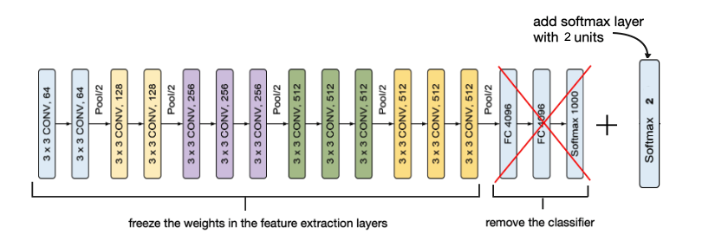

In [7]:
from torchvision.models import VGG16_Weights ## 사전학습된 VGG16를 이용하기 위해 import

## Classifier 부분은 제외하고 가져오기
base_model = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features

print(base_model)
summary_model(base_model, (3,224,224))## 모델 요약 정보 확인

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [8]:
## VGG16의 feature extractor의 파라미터 freeze
for para in base_model.parameters():
    para.requires_grad = False

summary_model(base_model,(3,224,224))## 모델 요약 정보 확인

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [9]:
## Classifier 만들기
classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512*7*7,64), ## 512, 7, 7
    nn.BatchNorm1d(64),
    nn.Dropout(0.5),
    nn.Linear(64,2), ## 512, 7, 7
#     nn.Softmax() ## CrossEntropy에 Softmax가 포함되므로 사용하지 않음
)

base_model.classifier = classifier ## 모델에 classifier라는 이름으로 추가
print(base_model)
summary_model(base_model, (3,224,224))## 모델 요약 정보 확인

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [10]:
# 모델 학습하기
import time

# 파라미터 설정
total_epoch = 20
best_loss = 100 ## loss를 기준으로 best_checkpoint를 저장하기 위해 100으로 설정하였음.

lr_rate = 0.0001
optimizer = torch.optim.Adam(base_model.parameters(), lr=lr_rate)## Adma을 최적화 함수로 이용함. 파라미터는 documentation을 참조!

loss = torch.nn.CrossEntropyLoss().cuda()## 분류문제이므로 CrossEntropyLoss를 이용함

## 모델 시각화를 위해 정확도를 저장할 리스트 생성
train_accuracys=[]
eval_accuracys=[]

for epoch in range(total_epoch):
    start = time.time()
    print(f'Epoch {epoch}/{total_epoch}')

    # train
    train_loss = 0
    correct = 0
    for x, target in trainloader:## 한번에 배치사이즈만큼 데이터를 불러와 모델을 학습함

        optimizer.zero_grad()## 이전 loss를 누적하지 않기 위해 0으로 설정해주는 과정
        
        y_pred = base_model(x.cuda())## 모델의 출력값
        
        cost = loss(y_pred, target.cuda())## loss 함수를 이용하여 오차를 계산함

        cost.backward() # gradient 구하기 
        optimizer.step()# 모델 학습
        train_loss += cost.item()
        
        pred = y_pred.data.max(1, keepdim=True)[1] ## 각 클래스의 확률 값 중 가장 큰 값을 가지는 클래스의 인덱스를 pred 변수로 받음
        correct += pred.cpu().eq(target.data.view_as(pred)).sum() # pred와 target을 비교하여 맞은 개수를 구하는 과정.
                                                                  # view_as함수는 들어가는 인수의 모양으로 맞춰주고, .eq()를 통해 pred와 target의 값이 동일한지 판단하여 True 개수 구하기
    
    train_loss /= len(trainloader)
        
    train_accuracy = correct / len(trainloader.dataset)
    train_accuracys.append(train_accuracy) ## 그래프로 표현하기 위해 리스트에 담음

    
    #Evaluate
    eval_loss = 0
    correct = 0
    with torch.no_grad(): ## 학습하지 않기 위해
        base_model.eval()# 평가 모드로 변경
        for x, target in validloader:
            y_pred = base_model(x.cuda())## 모델의 출력값
            cost = loss(y_pred, target.cuda())## loss 함수를 이용하여 valid 데이터의 오차를 계산함
            eval_loss += cost
            
            pred = y_pred.data.max(1, keepdim=True)[1]## 각 클래스의 확률 값 중 가장 큰 값을 가지는 클래스의 인덱스를 pred 변수로 받음
            correct += pred.cpu().eq(target.data.view_as(pred)).cpu().sum()# pred와 target을 비교하여 맞은 개수를 구하는 과정
            
        eval_loss /= len(validloader)
        eval_accuracy = correct / len(validloader.dataset)
        eval_accuracys.append(eval_accuracy)## 그래프로 표현하기 위해 리스트에 담음
        
        ## valid 데이터의 loss를 기준으로 이전 loss 보다 작을 경우 체크포인트 저장
        if eval_loss < best_loss:
            torch.save({
                'epoch': epoch,
                'model': base_model,
                'model_state_dict': base_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': cost.item,
                }, './bestCheckPoint.pth')
            
            print(f'Epoch {epoch:05d}: val_loss improved from {best_loss:.5f} to {eval_loss:.5f}, saving model to bestCheckPiont_resnet50.pth')
            best_loss = eval_loss
        else:
            print(f'Epoch {epoch:05d}: val_loss did not improve')
        base_model.train()
        
    print(f'{int(time.time() - start)}s - loss: {train_loss:.5f} - acc: {train_accuracy:.5f} - val_loss: {eval_loss:.5f} - val_acc: {eval_accuracy:.5f}')

Epoch 0/20
Epoch 00000: val_loss improved from 100.00000 to 0.11222, saving model to bestCheckPiont_resnet50.pth
4s - loss: 0.32379 - acc: 0.84158 - val_loss: 0.11222 - val_acc: 0.98058
Epoch 1/20
Epoch 00001: val_loss improved from 0.11222 to 0.09865, saving model to bestCheckPiont_resnet50.pth
3s - loss: 0.09327 - acc: 0.99010 - val_loss: 0.09865 - val_acc: 0.98058
Epoch 2/20
Epoch 00002: val_loss did not improve
3s - loss: 0.04795 - acc: 1.00000 - val_loss: 0.10738 - val_acc: 0.96117
Epoch 3/20
Epoch 00003: val_loss did not improve
3s - loss: 0.05526 - acc: 1.00000 - val_loss: 0.10990 - val_acc: 0.96117
Epoch 4/20
Epoch 00004: val_loss did not improve
3s - loss: 0.04185 - acc: 1.00000 - val_loss: 0.11112 - val_acc: 0.97087
Epoch 5/20
Epoch 00005: val_loss did not improve
3s - loss: 0.04459 - acc: 1.00000 - val_loss: 0.11282 - val_acc: 0.96117
Epoch 6/20
Epoch 00006: val_loss did not improve
3s - loss: 0.04017 - acc: 1.00000 - val_loss: 0.11569 - val_acc: 0.95146
Epoch 7/20
Epoch 000

In [11]:
## 저장되어있는 best 체크포인트 load하기
best_model = torch.load('./bestCheckPoint.pth')['model']  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
best_model.load_state_dict(torch.load('./bestCheckPoint.pth')['model_state_dict'])  # state_dict를 불러 온 후, 모델에 저장

<All keys matched successfully>

In [12]:
#prediction

correct = 0
total = 0
pred_=[]

with torch.no_grad(): ## 학습하지 않기 위해
    best_model.eval()
    for data, label in testloader:
        outputs = best_model(data.cuda())
        _, predicted = torch.max(outputs.data, 1)
        pred_.append(predicted.cpu().item()) ## 제출을 위해 예측값을 pred_로 받아줌
        total += label.size(0)
        correct += (predicted == label.cuda()).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


### The End

In [13]:
## pandas를 이용하여 sample.csv 파일 읽기
import pandas as pd

sample = pd.read_csv("/kaggle/input/2023-1-DLS-W6-P1/sample.csv")
sample.head()

,ID,label
0,12250,0
1,12251,0
2,12252,0
3,12253,0
4,12254,0


In [14]:
for i, info in enumerate(testloader.dataset.imgs):
    path = info[0]
    id = (path.split("/")[-1]).split(".")[-2] ## test 이미지의 ID를 찾는 방법 
    sample['label'][sample['ID']== int(id)]= pred_[i] ## sample의 ID에 맞추어 예측값 넣기

In [15]:
## csv 파일로 저장
sample.to_csv("baseline.csv",index=False,header=True)

In [16]:
sample

,ID,label
0,12250,0
1,12251,0
2,12252,0
3,12253,0
4,12254,0
...,...,...
446,12196,1
447,12197,1
448,12198,1
449,12199,1
